In [2]:
# === Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm

In [4]:
# Check GPU
if not torch.cuda.is_available():
    raise RuntimeError("CUDA GPU is not available. Please enable GPU in Colab (Runtime > Change runtime type > GPU).")
device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Paths
base_dir = "/content/drive/MyDrive/Arzoo_dataset_directory/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

In [6]:
# Hyperparameters
batch_size = 32
img_size = 224
epochs = 30
learning_rate = 1e-4
weight_decay = 1e-2

In [7]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [8]:
# Datasets and loaders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
class_names = train_dataset.classes

In [9]:
# Model: DenseNet201
model = models.densenet201(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 110MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [11]:
# Training loop
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
patience = 7
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / total_val * 100

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/30: 100%|██████████| 54/54 [08:32<00:00,  9.50s/it]



Train Loss: 0.5464 | Train Acc: 70.80%
Val Loss: 0.4231 | Val Acc: 80.56%


Epoch 2/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.2838 | Train Acc: 87.47%
Val Loss: 0.4975 | Val Acc: 77.16%


Epoch 3/30: 100%|██████████| 54/54 [00:42<00:00,  1.26it/s]



Train Loss: 0.1556 | Train Acc: 93.71%
Val Loss: 0.2793 | Val Acc: 89.51%


Epoch 4/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.1469 | Train Acc: 94.81%
Val Loss: 0.2737 | Val Acc: 87.35%


Epoch 5/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.1032 | Train Acc: 96.39%
Val Loss: 0.2807 | Val Acc: 88.89%


Epoch 6/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0883 | Train Acc: 97.20%
Val Loss: 0.1309 | Val Acc: 95.68%


Epoch 7/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0910 | Train Acc: 96.97%
Val Loss: 0.0964 | Val Acc: 95.37%


Epoch 8/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0512 | Train Acc: 98.37%
Val Loss: 0.2675 | Val Acc: 88.58%


Epoch 9/30: 100%|██████████| 54/54 [00:42<00:00,  1.26it/s]



Train Loss: 0.0563 | Train Acc: 97.79%
Val Loss: 0.1240 | Val Acc: 95.99%


Epoch 10/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0569 | Train Acc: 97.90%
Val Loss: 0.2126 | Val Acc: 91.67%


Epoch 11/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0760 | Train Acc: 96.91%
Val Loss: 0.1367 | Val Acc: 95.99%


Epoch 12/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0373 | Train Acc: 99.01%
Val Loss: 0.1103 | Val Acc: 95.99%


Epoch 13/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0204 | Train Acc: 99.77%
Val Loss: 0.1892 | Val Acc: 94.14%


Epoch 14/30: 100%|██████████| 54/54 [00:43<00:00,  1.25it/s]



Train Loss: 0.0239 | Train Acc: 99.30%
Val Loss: 0.2026 | Val Acc: 89.81%
Early stopping triggered.


In [12]:
# Save best model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "densenet201_best.pth")
print("Best model saved as densenet201_best.pth")

Best model saved as densenet201_best.pth


In [13]:
# ======= Evaluation =======
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [14]:
# Classification report
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)



Classification Report:
                   precision    recall  f1-score   support

converted_thermal     0.9349    0.9753    0.9547       162
     fake_thermal     0.9742    0.9321    0.9527       162

         accuracy                         0.9537       324
        macro avg     0.9546    0.9537    0.9537       324
     weighted avg     0.9546    0.9537    0.9537       324



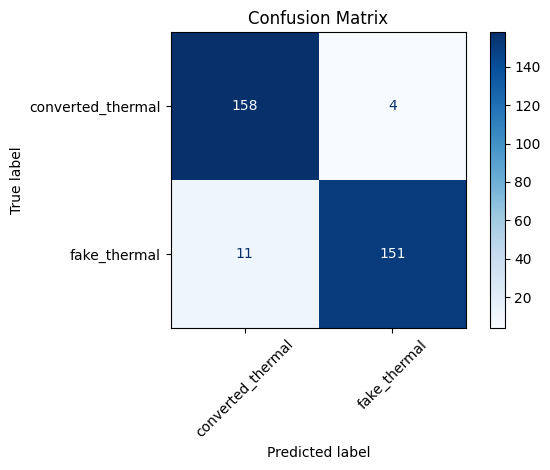

In [15]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_densenet.png")
plt.show()

In [16]:
# Save report
df = pd.DataFrame({
    "True Label": [class_names[i] for i in all_labels],
    "Predicted Label": [class_names[i] for i in all_preds]
})
df.to_csv("densenet201_eval_results.csv", index=False)
print("Saved: densenet201_eval_results.csv and confusion_matrix_densenet.png")

Saved: densenet201_eval_results.csv and confusion_matrix_densenet.png
